# Chess AI: MiniMax Algorithm

PURPOSE: create intelligent agent to serve as chess bot 

DETAILS: 
- using python-chess for all UI, chess-related features 
- agent references openings database until exhausting theory
- core game move selection is handled by minimax algorithm 

SOURCES: 
- polyglot openings book: https://www.chessprogramming.net/new-version-of-the-baron-v3-43-plus-the-barons-polyglot-opening-book/ 
- position tables for scoring: https://www.chessprogramming.org/Simplified_Evaluation_Function

### Packages + Data

In [73]:
## math, randomization
import numpy as np
import random

## copy board state prior to making move
from copy import deepcopy

## will need to keep track of time
import time

## library for chess UI
import chess
import chess.pgn
import chess.polyglot
from io import StringIO

## display stuff
from chess import svg
from IPython.display import clear_output

## graph illustration
import networkx as nx

In [74]:
# read in openings book (polyglot format):
opening_book = chess.polyglot.MemoryMappedReader('opening-books\Titans.bin')

### Coding the Chess Bot

Step 1: Define heuristic + wrapper functions for the agent to use when evaluating a given game state. 

In [80]:
# heuristic function 1: simple material based 
def material_scoring(board, turn=chess.WHITE): 

    """ assigns a score to the current game state based on collective material 
    1. create dictionary of piece key: values
    2. multiply dictionary by 1 or -1, depending on turn
    3. retrieve distribution of pieces on board
    4. sum values for these pieces
    """

    # 1. define dictionaries
    white_scoring = {
        'p': -100,
        'n': -300,
        'b': -300,
        'r': -500,
        'q': -900,
        'k': 0,
        'P': 100,
        'N': 300,
        'B': 300,
        'R': 500,
        'Q': 900,
        'K': 0,
    }

    # 2. create negated version for black
    black_scoring = {key: value * -1 for key, value in white_scoring.items()}

    # 3. retrieve distribution of pieces on board
    pieces = board.piece_map()

    # 4. sum values for pieces on board
    if turn == chess.WHITE:
        scoring = white_scoring
    else:
        scoring = black_scoring
    score = 0
    for key in pieces:
        score += scoring[str(pieces[key])]

    # output final score
    return score


# heuristic function 2: material and position
def material_plus_position_scoring(board, my_color): 

    """ assigns a score to the current game state based on collective material 
    1. create dictionary of piece key: values
    2. multiply dictionary by 1 or -1, depending on turn
    3. retrieve distribution of pieces on board
    4. sum values for these pieces
    """

    # DEFINE SCORING SYSTEMS -------------------------------------------------------------------------------

    ## material

    white_material_scoring = {
        'p': -1000,
        'n': -3000,
        'b': -3000,
        'r': -5000,
        'q': -9000,
        'k': 0,
        'P': 1000,
        'N': 3000,
        'B': 3000,
        'R': 5000,
        'Q': 9000,
        'K': 0,
    }

    black_material_scoring = {key: value * -1 for key, value in white_material_scoring.items()}

    ## position

    black_position_scoring = {

        'p': [0,  0,  0,  0,  0,  0,  0,  0,
              50, 50, 50, 50, 50, 50, 50, 50,
              10, 10, 20, 30, 30, 20, 10, 10, 
              5,  5, 10, 25, 25, 10,  5,  5,
              0,  0,  0, 20, 20,  0,  0,  0,
              5, -5,-10,  0,  0,-10, -5,  5,
              5, 10, 10,-20,-20, 10, 10,  5,
              0,  0,  0,  0,  0,  0,  0,  0], 

        'n': [-50,-40,-30,-30,-30,-30,-40,-50,
              -40,-20,  0,  0,  0,  0,-20,-40,
              -30,  0, 10, 15, 15, 10,  0,-30,
              -30,  5, 15, 20, 20, 15,  5,-30,
              -30,  0, 15, 20, 20, 15,  0,-30,
              -30,  5, 10, 15, 15, 10,  5,-30,
              -40,-20,  0,  5,  5,  0,-20,-40,
              -50,-40,-30,-30,-30,-30,-40,-50], 

        'b': [-20,-10,-10,-10,-10,-10,-10,-20,
              -10,  0,  0,  0,  0,  0,  0,-10,
              -10,  0,  5, 10, 10,  5,  0,-10,
              -10,  5,  5, 10, 10,  5,  5,-10, 
              -10,  0, 10, 10, 10, 10,  0,-10,
              -10, 10, 10, 10, 10, 10, 10,-10,
              -10,  5,  0,  0,  0,  0,  5,-10,
              -20,-10,-10,-10,-10,-10,-10,-20], 

        'r': [0,  0,  0,  0,  0,  0,  0,  0,
              5, 10, 10, 10, 10, 10, 10,  5,
              -5,  0,  0,  0,  0,  0,  0, -5,
              -5,  0,  0,  0,  0,  0,  0, -5,
              -5,  0,  0,  0,  0,  0,  0, -5,
              -5,  0,  0,  0,  0,  0,  0, -5,
              -5,  0,  0,  0,  0,  0,  0, -5,
              0,  0,  0,  5,  5,  0,  0,  0], 

        'q': [-20,-10,-10, -5, -5,-10,-10,-20,
              -10,  0,  0,  0,  0,  0,  0,-10,
              -10,  0,  5,  5,  5,  5,  0,-10,
              -5,  0,  5,  5,  5,  5,  0, -5,
               0,  0,  5,  5,  5,  5,  0, -5,
              -10,  5,  5,  5,  5,  5,  0,-10,
              -10,  0,  5,  0,  0,  0,  0,-10,
              -20,-10,-10, -5, -5,-10,-10,-20], 

        'k': [-30,-40,-40,-50,-50,-40,-40,-30,
              -30,-40,-40,-50,-50,-40,-40,-30,
              -30,-40,-40,-50,-50,-40,-40,-30,
              -30,-40,-40,-50,-50,-40,-40,-30,
              -20,-30,-30,-40,-40,-30,-30,-20,
              -10,-20,-20,-20,-20,-20,-20,-10,
               20, 20,  0,  0,  0,  0, 20, 20,
               20, 30, 10,  0,  0, 10, 30, 20]

    }

    white_position_scoring = {key.upper(): value[::-1] for key, value in black_position_scoring.items()}


    # DATA PREP -------------------------------------------------------------------------------------------------

    ## retrieve distribution of pieces on board
    pieces = board.piece_map()

    ## define scoring systems based on turn
    if my_color == "white":
        material_scoring = white_material_scoring
        position_scoring = white_position_scoring
        piece_positions  = {key: value for key, value in pieces.items() if str(value).isupper()}
    else:
        material_scoring = black_material_scoring
        position_scoring = black_position_scoring
        piece_positions  = {key: value for key, value in pieces.items() if str(value).islower()}

    # CALCULATE SCORE -------------------------------------------------------------------------------------------

    ## material scoring
    score = 0
    for key in pieces:
        
        score += material_scoring[str(pieces[key])]

    ## position_scoring
    for key in piece_positions: 
        
        score += position_scoring[str(piece_positions[key])][key]

    # OUTPUT
    return score


# wrapper function
def scoring_wrapper(game, scoring_function, my_color):
        
    """ assigns score to current game state using specified heuristic function and explicitly defined conditions
    args: 
    - game (chess.Board): current game state
    - my_turn (bool): T/F value indicating turn status
    - is_over (bool): T/F value indicating whether or not the game has ended
    - win (bool): T/F value indicating whether or not the player has won
    """

    # define game over variables
    is_over = game.is_checkmate()
    if len(game.move_stack) % 2 == 1: 
        winner = 'white'
    else: 
        winner = 'black'

    # if game is over, return inflated scores
    if is_over:
        if winner == my_color:
            return 100000
        else:
            return -100000

    # else return standard heuristic value
    return scoring_function(game, my_color)


Step 2: Define minimax function

In [85]:
class minimax_player(): 

    """ contains functions for executing minimax algorithm
    args: 
    - my_color (str): the chess agent's color in the current game
    - depth (int): OVERALL depth of search
    returns: 
    - best_move (chess.Move), best_score (int): tuple of best possible move and its associated score
    """

    def __init__(self, my_color='white', depth=5): 

        # our player's color
        self.my_color = my_color

        # depth of search
        self.depth = depth

        # tracker for explored game states
        self.state_scores = {}


    def minimax_core(self, game, d, alpha, beta, maximize=True): 

        """ retrieves move that maximizes score using alpha-beta pruning
        args: 
        - game (chess.Board): current game state
        - d (int): CURRENT depth of search
        - alpha (int): smallest score identified in subtree
        - beta (int): largest score identified in subtree
        returns: 
        - best_move (chess.Move), best_score (int): tuple of best possible move and its associated score
        """

        # check for base case
        if game.is_game_over() or d==0: 
            return scoring_wrapper(game, material_plus_position_scoring, self.my_color)

        if maximize: 

            # tracker variables
            best_move = None
            best_score = float("-inf")

            for move in game.legal_moves: 

                game.push(move)

                # check if game state has already been explored
                zobrist = chess.polyglot.zobrist_hash(game)  ## zobrist hash of chess board
                if zobrist in self.state_scores.keys(): 
                    score = self.state_scores[zobrist]
                    self.state_scores[zobrist] = score
                
                # else continue recursion 
                else: 
                    score = self.minimax_core(game, d-1, alpha, beta, False)

                game.pop()

                # check for best score
                if score > best_score: 
                    best_move = move
                    best_score = score
                
                # alpha-beta pruning 
                if best_score > beta: 
                    break
                alpha = max(alpha, best_score)

        else: 

            # tracker variables
            best_move = None
            best_score = float("inf")

            for move in game.legal_moves: 

                game.push(move)

                # check if game state has already been explored
                zobrist = chess.polyglot.zobrist_hash(game)  ## zobrist hash of chess board
                if zobrist in self.state_scores.keys(): 
                    score = self.state_scores[zobrist]
                
                # else continue recursion
                else: 
                    score = self.minimax_core(game, d-1, alpha, beta, True)
                    self.state_scores[zobrist] = score

                game.pop()

                # check for best score
                if score < best_score: 
                    best_move = move
                    best_score = score

                # alpha-beta pruning
                if best_score < alpha: 
                    break
                beta = min(beta, best_score) 

        return best_score
            
    def minimax_wrapper(self, game, alpha=float('-inf'), beta=float('inf')): 

        # trackers
        best_move = None
        best_score = float('-inf')

        for first_move in game.legal_moves:
            
            # retrieve score for given move
            game.push(first_move)
            score = self.minimax_core(game, self.depth-1, alpha, beta, False)
            game.pop()

            # determine best move 
            if score > best_score:
                best_score = score
                best_move = first_move
                
            print(first_move, score)

        return best_move

Step 3: Create wrapper function to call minimax:
- if meets predefined opening conditions -> hard-programmed opening book
- else minimax function

In [86]:
def get_move(game, player, depth): 

    """ retrieves next move for chess bot. if opening conditions are met, queries openings database. else calls minimax
    args: 
    - game (chess.Board): current game state
    - depth (int): search depth
    returns: 
    - choice_move (chess.Move), choice_name (str): chosen move and associated opening name
    """

    # retrieve opening book data for provided game state
    opening_moves = opening_book.find_all(game)
    opening_count = sum(1 for _ in opening_moves)

    # if there is opening data, use weighted random selection to choose move
    if opening_count != 0: 
        choice_move = opening_book.weighted_choice(game).move
        
    # else call minimax algorithm 
    else: 
        choice_move = player.minimax_wrapper(game, depth)

    return choice_move

Step 4: Combine everything into interactive game

In [87]:
def play_game(depth=5): 

    """ allows user to play a game of chess against bot in ipynb 
    args: 
    - depth (int): search depth
    """

    # randomly assign players
    randint = random.choice([0, 1])

    if randint == 0: 
        ai_color  = "white"
        your_color = "black"
    else: 
        ai_color   = "black"
        your_color = "white"

    # initialize game, minimax algorithm
    game = chess.Board()
    my_minimax = minimax_player(ai_color, depth)
    move_counter = 0

    while not game.is_game_over():

        ## define previous move
        if move_counter == 0:
            last_move = None
        else: 
            last_move = game.move_stack[-1]

        ## clear previous board state, display current board state
        clear_output()
        display(chess.svg.board(game, size=450, lastmove=last_move))
        display(f'YOU: {your_color}  BOT: {ai_color}')
        
        ## game logic
        ### whose turn is it? 
        if game.turn == chess.WHITE:
            turn = "white"
        else: 
            turn = "black"

        ### if ai's turn, call minimax. else, prompt user for input
        if turn == ai_color: 
            move = get_move(game, my_minimax, depth)
            game.push(move)
        else: 
            move = input("YOUR MOVE:\n")
            try: 
                game.push_san(move)
            except: 
                display("ERROR: please enter a legal move")

        move_counter += 1

    # display final position
    clear_output()
    display(chess.svg.board(game, size=450))

    # winner
    ## determine winner
    if turn == "white":
        winner = "White"
    else:
        winner = "Black"

    ## output message
    print(f"GAME OVER: {winner} wins!")
        
        

### Testing

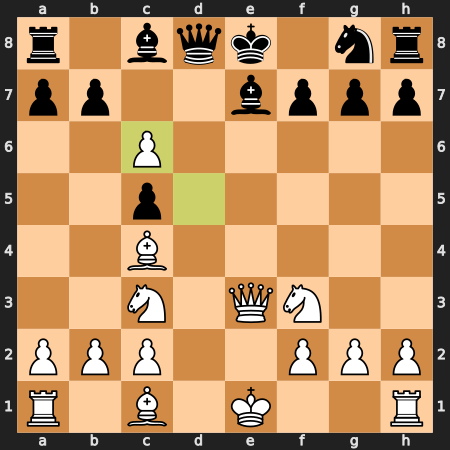

'YOU: black  BOT: white'

KeyboardInterrupt: Interrupted by user

In [89]:
play_game(depth=5)

### Generate Images/Stats for GitHub

Openings:

In [10]:
def get_opening_moves(game): 
    """ retrieves all moves and associated weights for given position
    args: 
    - game (chess.Board): current game state
    returns: 
    - moves (dict): dictionary containing move: weight pairs
    """

    # retrieve all possible continuations in openings book 
    opening_moves = opening_book.find_all(game)

    move_counter = 0
    moves = {}

    for move in opening_moves: 
        move_counter += 1
        moves[move.move] = move.weight

    return moves


In [102]:
game = chess.Board()
game.push_san('e2e4')
game.push_san('e7e5')
game.push_san('g1f3')
game.push_san('b8c6')

Move.from_uci('b8c6')

In [12]:
next_moves = get_opening_moves(game)

for move, weight in next_moves.items():
    print(f'{move}: {weight}')

f1b5: 9755
f1c4: 1449
d2d4: 1051
b1c3: 443
c2c3: 27


Minimax Exploration:

In [12]:
game = chess.Board()
game.push_san('e2e4')
game.push_san('e7e5')
game.push_san('g1f3')
game.push_san('b8c6')
game.push_san('f1b5')
game.push_san('a7a6')
game.push_san('b5c4')
game.push_san('b7b5')

Move.from_uci('b7b5')

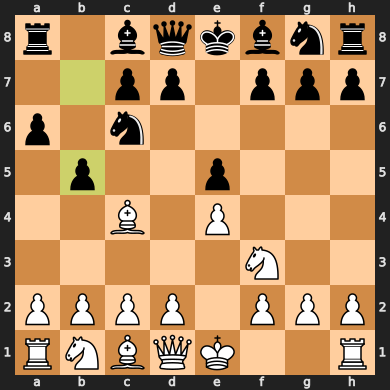

In [104]:
game

In [105]:
minimax_player = minimax('white', 5)
minimax_player.minimax_search(game)

(Move.from_uci('f3e5'), 125)

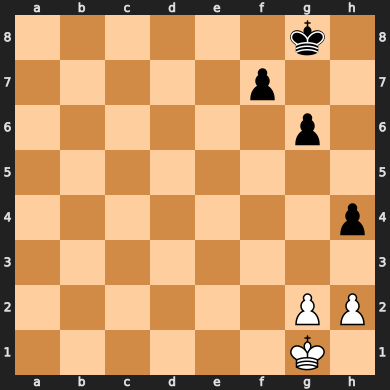

In [103]:
test_game = chess.Board('6k1/5p2/6p1/8/7p/8/6PP/6K1 b - - 0 0')
test_game

In [106]:
my_minimax = minimax_player()
my_minimax.minimax_wrapper(test_game, depth=5)

KeyboardInterrupt: 

### Unit Testing

Scoring Function:

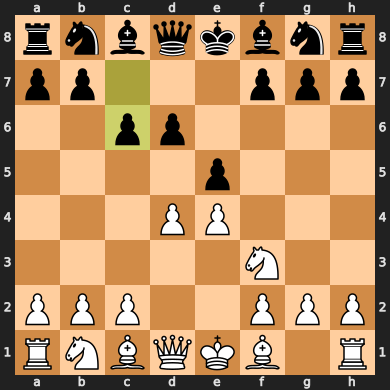

In [21]:
test_game2 = chess.Board()

test_game2.push_san('e2e4')
test_game2.push_san('e7e5')
test_game2.push_san('d2d4')
test_game2.push_san('d7d6')
test_game2.push_san('g1f3')
test_game2.push_san('c7c6')
# test_game2.push_san('f3e5')
# test_game2.push_san('d6e5')
test_game2

In [93]:
scoring_wrapper(test_game2, material_plus_position_scoring, 'white')

35

Minimax: 

In [63]:
my_player = minimax_player(my_color='white', depth=3)
my_player.minimax_wrapper(test_game2, 3)

f3g5 20
f3e5 -970
f3h4 -1970
f3d2 -940
f3g1 -25
h1g1 25
f1a6 -1945
f1b5 -1945
f1c4 45
f1d3 45
f1e2 35
e1e2 25
e1d2 25
d1d3 35
d1e2 30
d1d2 30
c1h6 -1945
c1g5 100
c1f4 -2905
c1e3 45
c1d2 35
b1c3 75
b1a3 35
b1d2 70
d4e5 1090
d4d5 25
h2h3 25
g2g3 10
c2c3 25
b2b3 10
a2a3 25
h2h4 20
g2g4 15
c2c4 15
b2b4 15
a2a4 20


Move.from_uci('d4e5')

In [72]:
my_player = minimax_player(my_color='white', depth=3)
my_player.minimax_wrapper(test_game2, 3)

f3g5 20
f3e5 -970
f3h4 -1970
f3d2 -940
f3g1 -25
h1g1 25
f1a6 -1945
f1b5 -1945
f1c4 45
f1d3 45
f1e2 35
e1e2 25
e1d2 25
d1d3 35
d1e2 30
d1d2 30
c1h6 -1945
c1g5 100
c1f4 -2905
c1e3 45
c1d2 35
b1c3 75
b1a3 35
b1d2 70
d4e5 1090
d4d5 25
h2h3 25
g2g3 10
c2c3 25
b2b3 10
a2a3 25
h2h4 20
g2g4 15
c2c4 15
b2b4 15
a2a4 20


Move.from_uci('d4e5')